# Music, Mental Health, and Emotion

## Datasets

### Music & Mental Health Survey Results
Link to Dataset: (https://www.kaggle.com/datasets/catherinerasgaitis/mxmh-survey-results)

Intial EDA for this dataset may be found in []()

> Music therapy, or MT, is the use of music to improve an individual's stress, mood, and overall mental health. MT is also recognized as an evidence-based practice, using music as a catalyst for "happy" hormones such as oxytocin.

### 278k Emotion Labeled Spotify Songs
Link to Dataset: (https://www.kaggle.com/datasets/abdullahorzan/moodify-dataset)

Initial EDA for this dataset may be found in []()

> The main idea of Moodify project is to classify songs not only based on their lyrical and musical features, but also incorporating emotions, in order to provide users with more successful recommendation outputs. Moodify aims to categorize songs into four main emotions and utilize the similarities in musical features within these categories to offer users more effective recommendations, weighting them with emotions.

## Research 
***How do individuals' self-reported music preferences correlate with their mental health indicators, and can emotional trends in the Emotion Labeled Spotify Songs Dataset provide additional insights into these relationships?***

### Objectives
- Assign respective genres to emotion labeled Spotify songs.
- Identify any emotional trends associated with assigned genres.
- Determine any correlations between music preference and mental health indicators.
- Relate music/mental health correlations to identified emotional trends.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap
import os
from dotenv import load_dotenv
import time
import requests
import math
import ast

### Assign Respective Genres to Emotion Labeled Spotify Songs

In [215]:
load_dotenv()

client_id = os.environ.get('SPOTIPY_CLIENT_ID')
client_secret = os.environ.get('SPOTIPY_CLIENT_SECRET')

AUTH_URL = 'https://accounts.spotify.com/api/token'
BASE_URL = 'https://api.spotify.com/v1/'

# Create TokenMangager to refresh spotify access token if nearing expiration
class TokenManager:
    def __init__(self):
        self.access_token = None
        self.expires_at = None
        self.headers = None

    def set_token(self, access_token, expires_at):
        self.access_token = access_token
        self.expires_at = expires_at
        self.headers = {
            'Authorization': 'Bearer {token}'.format(token=access_token)
        }

    # Make POST request for access token using clien key and secret
    def refresh_token(self):
        auth_response = requests.post(AUTH_URL, {
            'grant_type': 'client_credentials',
            'client_id': client_id,
            'client_secret': client_secret,
            })
        
        print("Refreshing access token...")
        
        auth_response_data = auth_response.json()

        access_token = auth_response_data['access_token']
        expires_at = time.time() + 3600 # 1 hour
        
        self.set_token(access_token=access_token, expires_at=expires_at)

    # Check if token is nearing expiration
    def is_token_near_expiry(self, refresh_threshold=300):  # 300 seconds = 5 minutes
        if self.expires_at is None:
            return False

        current_time = time.time()
        refresh_time = self.expires_at - refresh_threshold

        # Check if the current time is within the refresh threshold
        return current_time >= refresh_time

In [216]:
# Edit copy df just in case
enhanced_elss_df = elss_df.copy()
enhanced_elss_df.head()

enhanced_elss_df['artist_name'] = None
enhanced_elss_df['track_name'] = None
enhanced_elss_df['genres'] = None
enhanced_elss_df.head()

# Get batch of tracks followed by batch of artists to be added to the elss df
def get_track_details_batch(track_uris, token_manager):
    try:
        TRACKS_URL = BASE_URL + 'tracks?ids=' + ','.join(track_uris)
        track_info = requests.get(TRACKS_URL, headers=token_manager.headers)  
        track_info = track_info.json()['tracks']
        
        artist_ids = [track['artists'][0]['id'] for track in track_info]
        ARTISTS_URL = BASE_URL + 'artists?ids=' + ','.join(artist_ids)
        artist_info = requests.get(ARTISTS_URL, headers=token_manager.headers)
        artist_info = artist_info.json()['artists']

        details = []
        for i, track in enumerate(track_info):
            track_id = track['id']
            track_name = track['name']
            artist_name = artist_info[i]['name']
            genres = artist_info[i]['genres']
            details.append((track_id, track_name, artist_name, genres))
        return details
    except Exception as e:
        print(f"Exception {e}")
        return None

# Add track_id, track_artist, artist_name, and list of genres to each track in elss df
def add_track_details(df, batch_size, token_manager):
    batches = math.ceil(len(df) / batch_size)
    # Fetch track details in batches and update DataFrame
    for i in range(262894, len(df), batch_size):
        batch_num = i // batch_size
        end_index = min(i + batch_size, len(df))  # Adjusted end index
        batch_track_ids = [uri.split(':')[-1] for uri in df['uri'].iloc[i:end_index].tolist()]
        
        # Check tocken status and refresh if needed
        if token_manager.is_token_near_expiry():
            token_manager.refresh_token()
        
        # Add new cols to df
        details_batch = get_track_details_batch(batch_track_ids, token_manager)
        for j, details in enumerate(details_batch):
            if details is not None:
                index = i + j
                df.at[index, 'track_id'], df.at[index, 'track_name'], df.at[index, 'artist_name'], df.at[index, 'genres'] = details
        print(f"Finished adding track details for batch {batch_num} / {batches}")
        print("Last row of batch: ")
        print(df.iloc[i + batch_size - 1])
        time.sleep(3)
        
token_manager = TokenManager()
token_manager.refresh_token()

batch_size = 50
# add_track_details(enhanced_elss_df, batch_size=batch_size, token_manager=token_manager)

Refreshing access token...


In [217]:
combined_df = pd.read_csv('../data/combined_df.csv', low_memory=False)

In [218]:
combined_df['genres'] = combined_df['genres'].replace(to_replace=['[]'], value=np.nan)
combined_df = combined_df.dropna(subset=['artist_name', 'track_name','genres', 'track_id'])

# Explode genre list out
combined_df['genres'] = combined_df['genres'].apply(ast.literal_eval)
expanded_df = combined_df.explode('genres')

# Reset col type for future use
combined_df['genres'] = combined_df['genres'].astype(str)

expanded_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 639041 entries, 1 to 277937
Data columns (total 22 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   duration (ms)       639041 non-null  float64
 1   danceability        639041 non-null  float64
 2   energy              639041 non-null  float64
 3   loudness            639041 non-null  float64
 4   speechiness         639041 non-null  float64
 5   acousticness        639041 non-null  float64
 6   instrumentalness    639041 non-null  float64
 7   liveness            639041 non-null  float64
 8   valence             639041 non-null  float64
 9   tempo               639041 non-null  float64
 10  spec_rate           639041 non-null  float64
 11  labels              639041 non-null  int64  
 12  uri                 639041 non-null  object 
 13  duration (sec)      639041 non-null  float64
 14  duration (min)      639041 non-null  float64
 15  duration (min:sec)  639041 non-null  ob

In [219]:
# Get count of new all genres from the exploded genres
genre_counts = expanded_df['genres'].value_counts()
genre_counts.info()

<class 'pandas.core.series.Series'>
Index: 5102 entries, rock to vintage swoon
Series name: count
Non-Null Count  Dtype
--------------  -----
5102 non-null   int64
dtypes: int64(1)
memory usage: 79.7+ KB


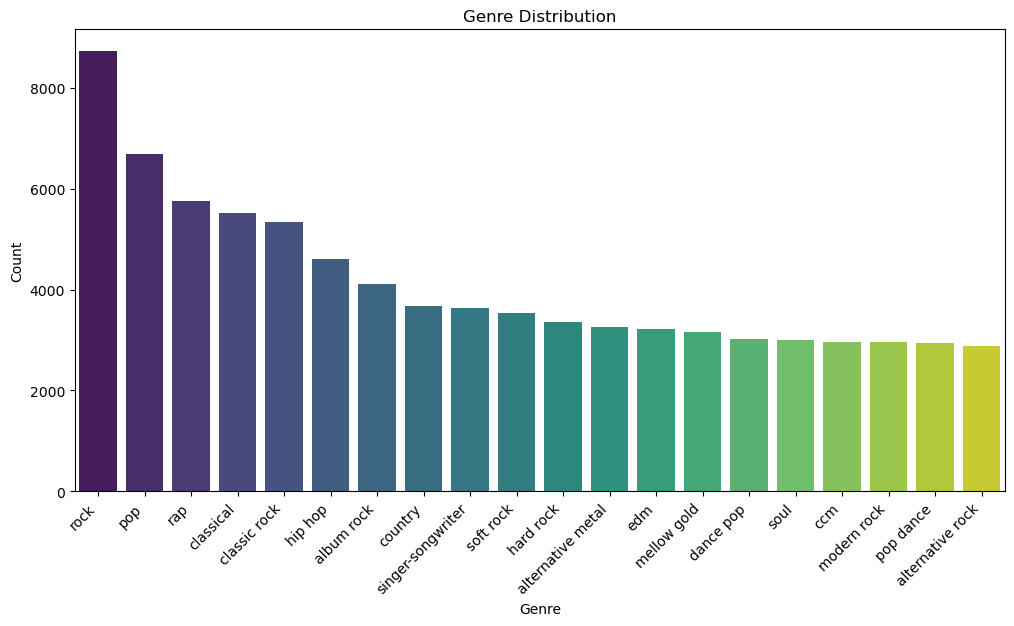

In [220]:
top_n_genre_counts = genre_counts.head(20)


# Plot the genre distribution
plt.figure(figsize=(12, 6))
sns.barplot(x=top_n_genre_counts.index, y=top_n_genre_counts.values, palette="viridis")
plt.title('Genre Distribution')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

As you can see the top 5 genres are Rock, Pop, Rap, Classical, and Classic Rock. Metal has a lot of overlap with rock likely adding to rock's lead. 

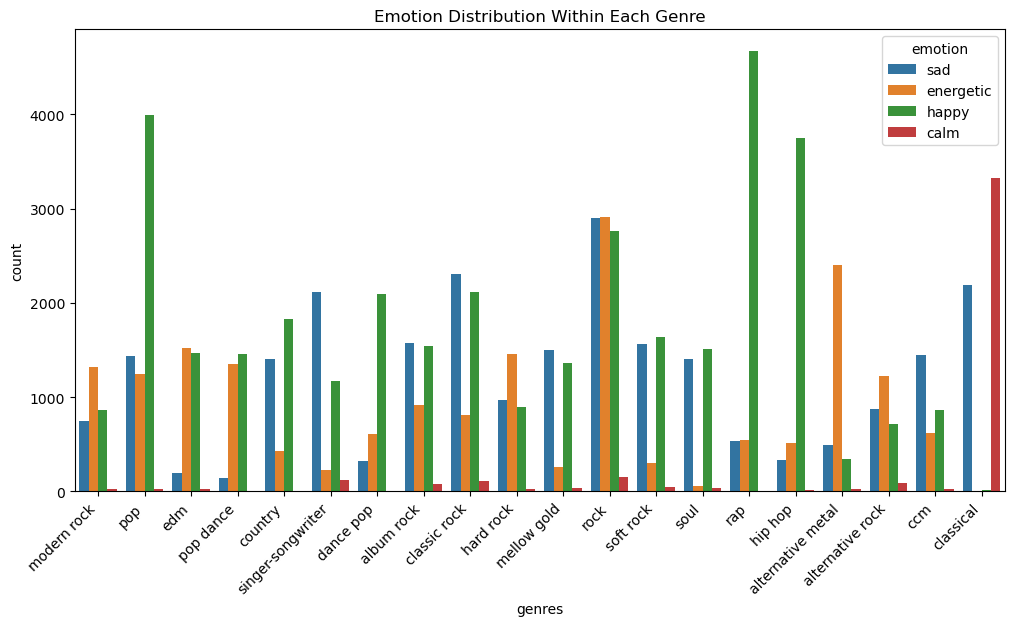

In [221]:
# Get full df of top n genres
top_n_genres = top_n_genre_counts.index.tolist()
filtered_df = expanded_df[expanded_df['genres'].isin(top_n_genres)]

hue_order = ['sad', 'energetic', 'happy', 'calm']



# Emotion distribution within each genre
plt.figure(figsize=(12, 6))
sns.countplot(x='genres', hue='emotion', data=filtered_df,hue_order=hue_order)
plt.title('Emotion Distribution Within Each Genre')
plt.xticks(rotation=45, ha='right')
plt.show()

#### Key Genre Distribution Findings: 
- High happiness distribution for Rap, Hip Hop, EDM, and Pop.
- High sadness distribution for Rock, Classical, Singer-Songwriter, and ccm.
- Low happiness distribution for Metal and Classical. 
- Low sadness distribution for EDM, Rap, and Pop. 
- High calm distribution in Classical.
- High energetic distribution in metal, some rock genres/subgenres, and edm.

In [222]:
# genre_stats = filtered_df.groupby('genres')['emotion'].describe()
genre_map = {
    'Rock': ['rock'],
    'Pop': ['pop'],
    'Metal': ['metal'],
    'Classical': ['classical'],
    'Video game music': ['video game music'],
    'EDM': ['edm'],
    'R&B': ['r&b'],
    'Hip hop': ['hip hop'],
    'Folk': ['folk'],
    'K pop': ['k pop'],
    'Country': ['country'],
    'Rap': ['rap'],
    'Jazz': ['jazz'],
    'Lofi': ['lofi'],   
    'Gospel': ['gospel'],   
    'Latin': ['latin']   
}

# Map subgenres to main genre listed in mxmh
def map_to_main_genre(genre):
    main_genres = []
    for main_genre, sub_genres in genre_map.items():
        if any(sub_genre in genre for sub_genre in sub_genres):
            main_genres.append(main_genre)
    return main_genres

# Add mapped genre to expanded elss df
expanded_df['mxmh_genres'] = expanded_df['genres'].apply(map_to_main_genre)

expanded_df[['genres', 'mxmh_genres']].head()

expanded_by_main_genre_df = expanded_df.explode('mxmh_genres')
expanded_by_main_genre_df = expanded_by_main_genre_df.dropna(subset=['mxmh_genres'])
# expanded_by_main_genre_df['mxmh_genres'] = expanded_by_main_genre_df['mxmh_genres'].astype(str)


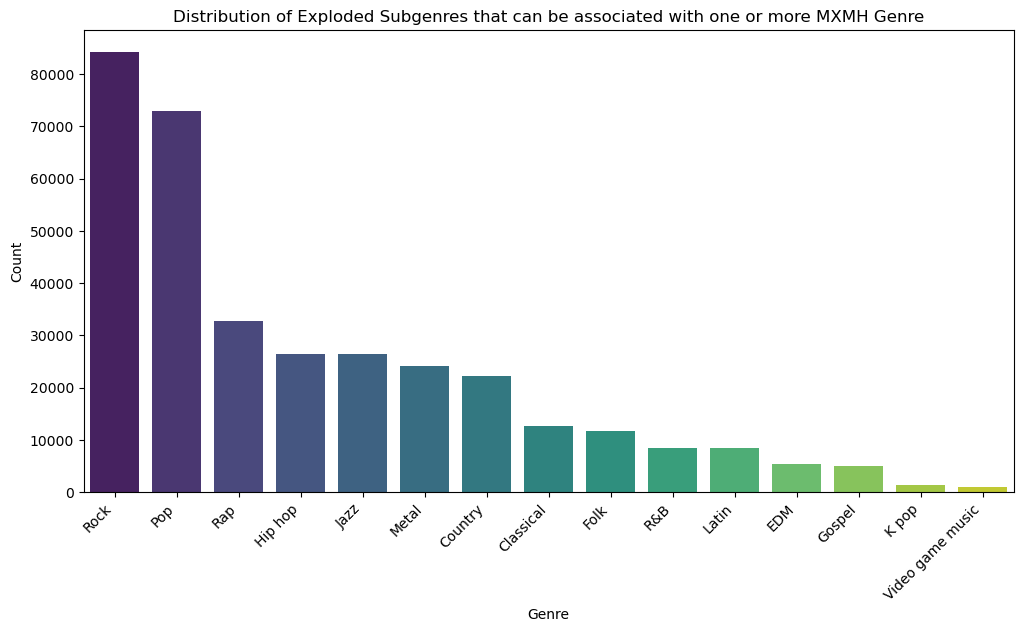

In [223]:
related_genre_counts = expanded_by_main_genre_df['mxmh_genres'].value_counts()

# Plot the genre distribution of the exploded rows with associated mxmh genre
plt.figure(figsize=(12, 6))
sns.barplot(x=related_genre_counts.index, y=related_genre_counts.values, palette="viridis")
plt.title('Distribution of Exploded Subgenres that can be associated with one or more MXMH Genre')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

As seen, Rock, Pop, Rap, Hip hop, and Jazz are now the top genres in our expanded dataset.

Genres prior to exploding ds: Rock, Pop, Rap, Classical, and Classic Rock.

A big factor of this difference is lack of subgenre mappins for initial analysis.

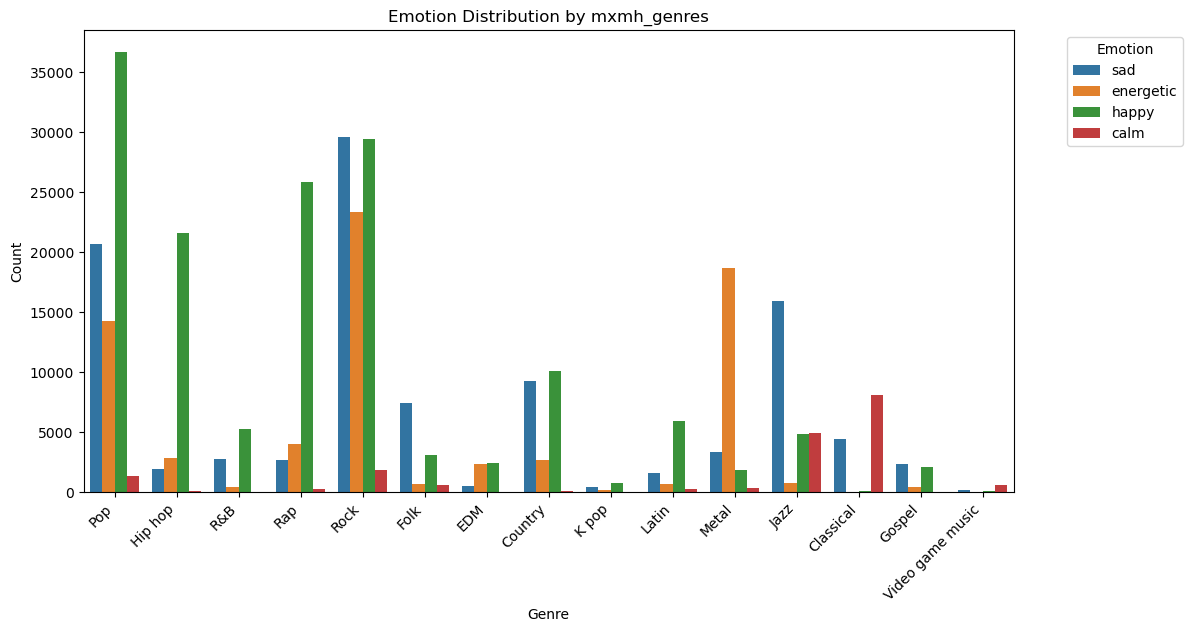

In [224]:
# Plot Emotion distribution of exploded rows by mxmh genre
plt.figure(figsize=(12, 6))
sns.countplot(x='mxmh_genres', hue='emotion', data=expanded_by_main_genre_df, hue_order=hue_order)
plt.title('Emotion Distribution by mxmh_genres')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Emotion', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

#### Key Findings: 
- High happiness distribution for Pop, Hip hop, Rap, Rock, and Country.
- High sadness distribution for Rock, Folk, Country, Jazz, and Gospel. 
- Low happiness distribution for Classical and Metal.
- Low sadness distribution for Hip hop, Rap, EDM, and Metal.
- High energetic distribution for Metal.
- High calming distribution for Classical.

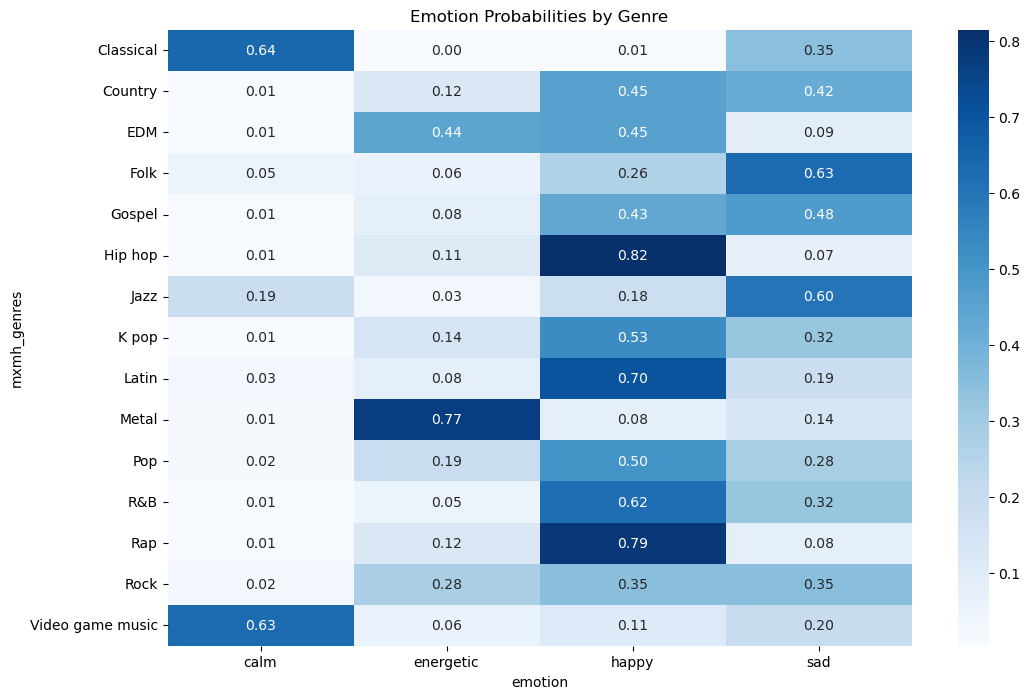

In [225]:
# Extract the relevant columns
genre_emotion_subset = expanded_by_main_genre_df[['mxmh_genres', 'emotion']]

# Create a contingency table
contingency_table = pd.crosstab(genre_emotion_subset['mxmh_genres'], genre_emotion_subset['emotion'])

# Normalize the contingency table to obtain probabilities
probabilities = contingency_table.div(contingency_table.sum(axis=1), axis=0)

plt.figure(figsize=(12, 8))
sns.heatmap(probabilities, cmap="Blues", annot=True, fmt=".2f", cbar=True)
plt.title('Emotion Probabilities by Genre')
plt.show()

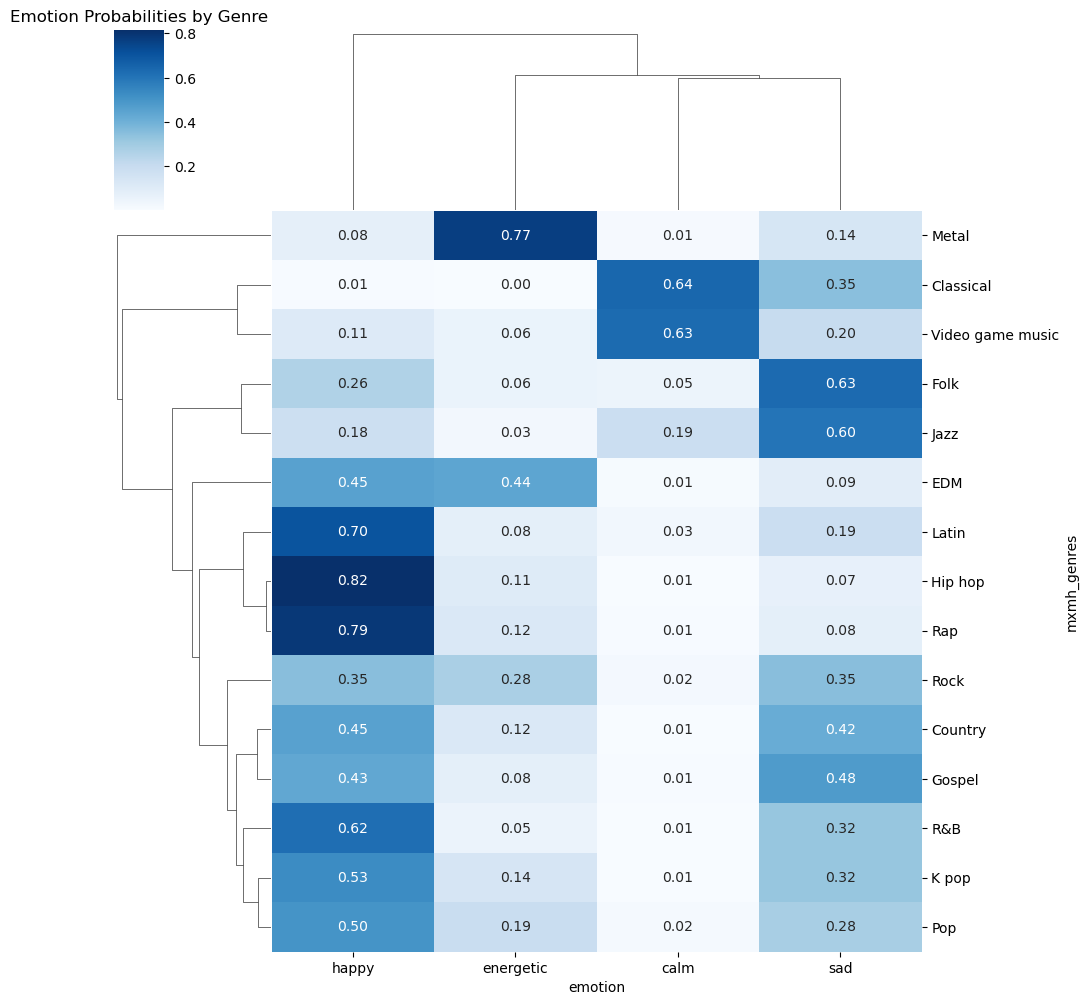

In [226]:
sns.clustermap(probabilities, cmap="Blues", annot=True, fmt=".2f", col_cluster=True, row_cluster=True)
plt.title('Emotion Probabilities by Genre')
plt.show()

<Axes: >

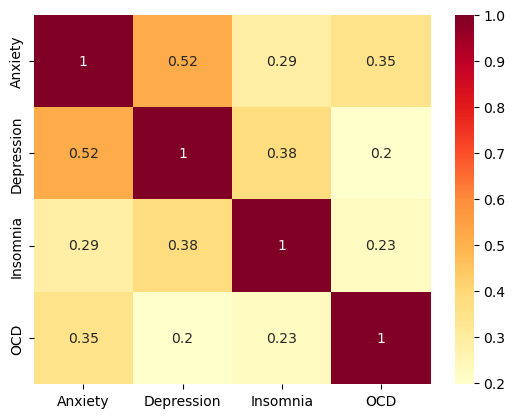

In [227]:
mxmh_rankings = ['Anxiety', 'Depression', 'Insomnia', 'OCD']

mxmh_ranking_df = mxmh_df[mxmh_rankings]
mxmh_ranking_corr = mxmh_ranking_df.corr()
sns.heatmap(mxmh_ranking_corr, annot=True, cmap = 'YlOrRd')

#### Key Findings:
- High correlation between Anxiety and Depression.
- A slight correlation between Anxiety and OCD.
- A slight correlation between Depression and Insomnia. 

In [228]:
mxmh_df.insert(0, "Surveyee ID", mxmh_df.index) # Add an identifier to the surveyees 

Individuals w: 701
Individuals w/ any self-reported Anxiety: 701
Individuals w/ any self-reported Depression: 652
Individuals w/ any self-reported Insomnia: 587
Individuals w/ any self-reported OCD: 488
Combined Validation: 2428


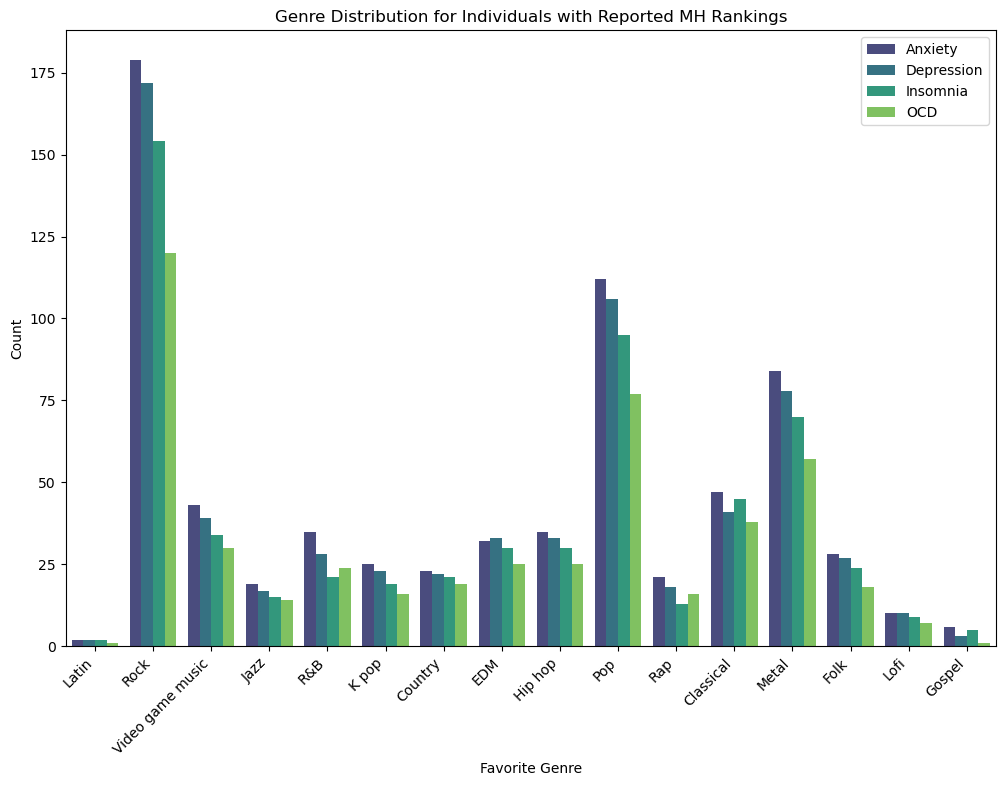

In [229]:
anxiety_df = mxmh_df[mxmh_df['Anxiety'] > 0].copy()
anxiety_count = anxiety_df.shape[0]

depression_df = mxmh_df[mxmh_df['Depression'] > 0].copy()
depression_count = depression_df.shape[0]

insomnia_df = mxmh_df[mxmh_df['Insomnia'] > 0].copy()
insomnia_count = insomnia_df.shape[0]

ocd_df = mxmh_df[mxmh_df['OCD'] > 0].copy()
ocd_count = ocd_df.shape[0]

pd.set_option('display.max_rows', None)

total_surveyees = mxmh_df.shape[0]
surveyees_reporting_mh = anxiety_count + depression_count + insomnia_count + ocd_count


print(f"Individuals w: {anxiety_count}")
print(f"Individuals w/ any self-reported Anxiety: {anxiety_count}")
print(f"Individuals w/ any self-reported Depression: {depression_count}")
print(f"Individuals w/ any self-reported Insomnia: {insomnia_count}")
print(f"Individuals w/ any self-reported OCD: {ocd_count}")

print(f"Combined Validation: {surveyees_reporting_mh}")

keys = ['Anxiety', 'Depression', 'Insomnia', 'OCD']

all_disorders_df = pd.concat([anxiety_df, depression_df, insomnia_df, ocd_df], keys=keys, names=["Condition"])
all_disorders_df = all_disorders_df.reset_index().drop(columns=["level_1"])

plt.figure(figsize=(12, 8))

sns.countplot(x='Fav genre', data=all_disorders_df, hue="Condition", palette='viridis')
plt.title('Genre Distribution for Individuals with Reported MH Rankings')
plt.xlabel('Favorite Genre')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')  
plt.legend()
plt.show()

In [230]:
# Create cluster maps of mental health rankings
def create_mg_genre_clustermap(df, mh_category):
    # Bin the anxiety scores into categories for easier visualization
    df[f"{mh_category}_Category"] = pd.cut(df[mh_category], bins=[0, 3, 5, 7, 10], labels=['Low', 'Medium-Low', 'Medium-High', 'High'])

    # Create a contingency table of 'Fav genre' and mh_category
    contingency_table = pd.crosstab(df['Fav genre'], df[f"{mh_category}_Category"], normalize='index')    

    # Create a clustermap
    plt.figure(figsize=(10, 8))
    sns.clustermap(contingency_table, cmap="Blues", annot=True, fmt=".2f", col_cluster=True, row_cluster=True, cbar=True)
    plt.title(f'Genre Probability Cluster Map for {mh_category} Ranking')
    plt.xlabel(f'{mh_category} Category')
    plt.ylabel('Favorite Genre')
    plt.show()

# Create genre plots of mental health rankings
def create_mh_genre_plot(df, mh_category):
    # df[f'{mh_category}_Category'] = pd.cut(df[mh_category], bins=[0, 3, 5, 7, 10], labels=['Low', 'Medium-Low', 'Medium-High', 'High'])
    
    counts_df = mxmh_df.groupby(['Fav genre', f'{mh_category}_Category']).size().unstack(fill_value=0)
    
    # Create a stacked bar plot
    plt.figure(figsize=(30, 10))
    counts_df.plot(kind='bar', stacked=True, colormap='coolwarm')
    plt.title(f'{mh_category} and Genre Distribution')
    plt.xlabel('Favorite Genre')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')  
    plt.legend(title=f'{mh_category} Category', bbox_to_anchor=(1.05, 1), loc='upper left')  
    plt.show()


As a result of low survey data, I will focus on Rock, Pop, and Metal. 

<Figure size 1000x800 with 0 Axes>

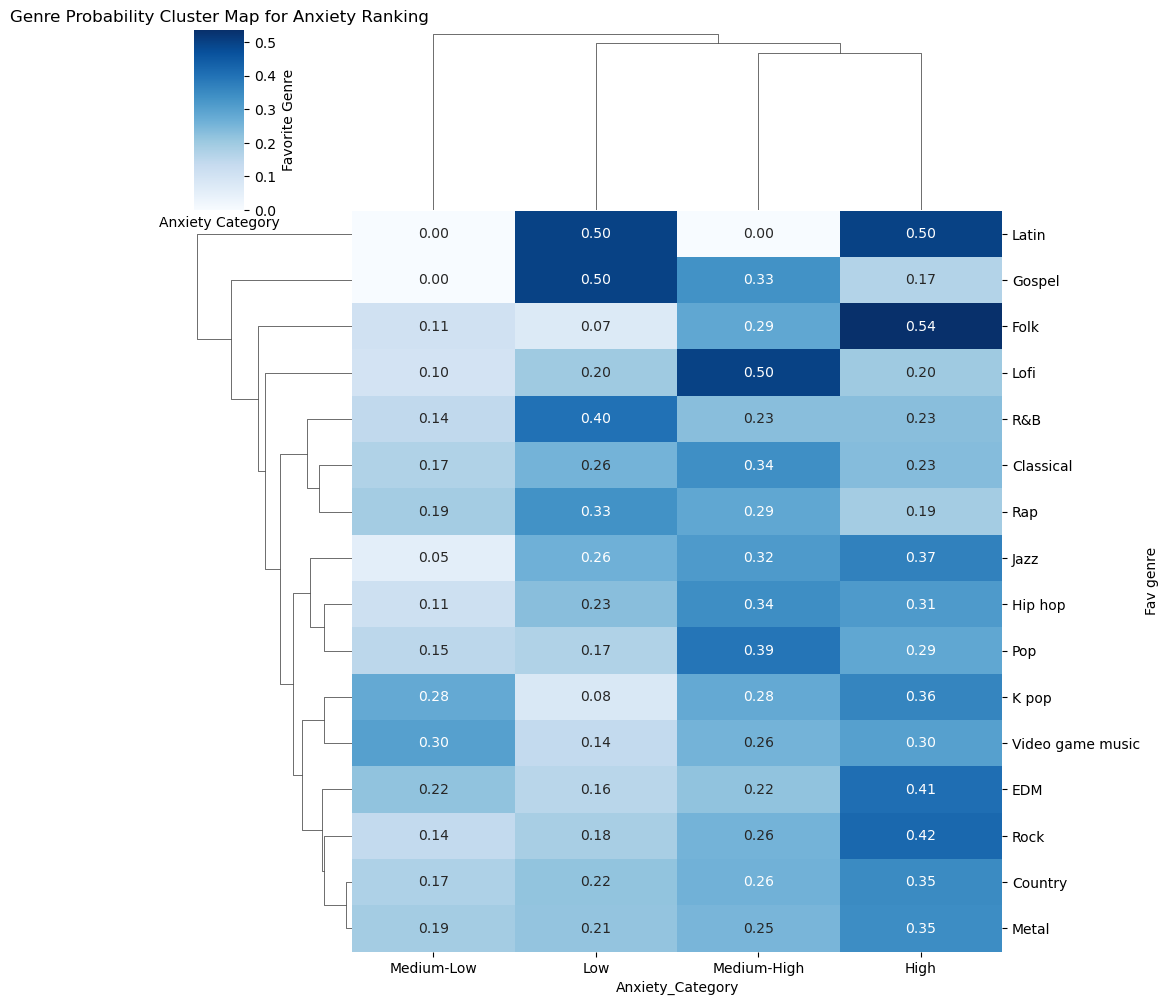

In [231]:
create_mg_genre_clustermap(mxmh_df, 'Anxiety')

Findings:
- Recognizable correspondance of high anxiety and fav genre of Rock, Metal, and Pop.

<Figure size 1000x800 with 0 Axes>

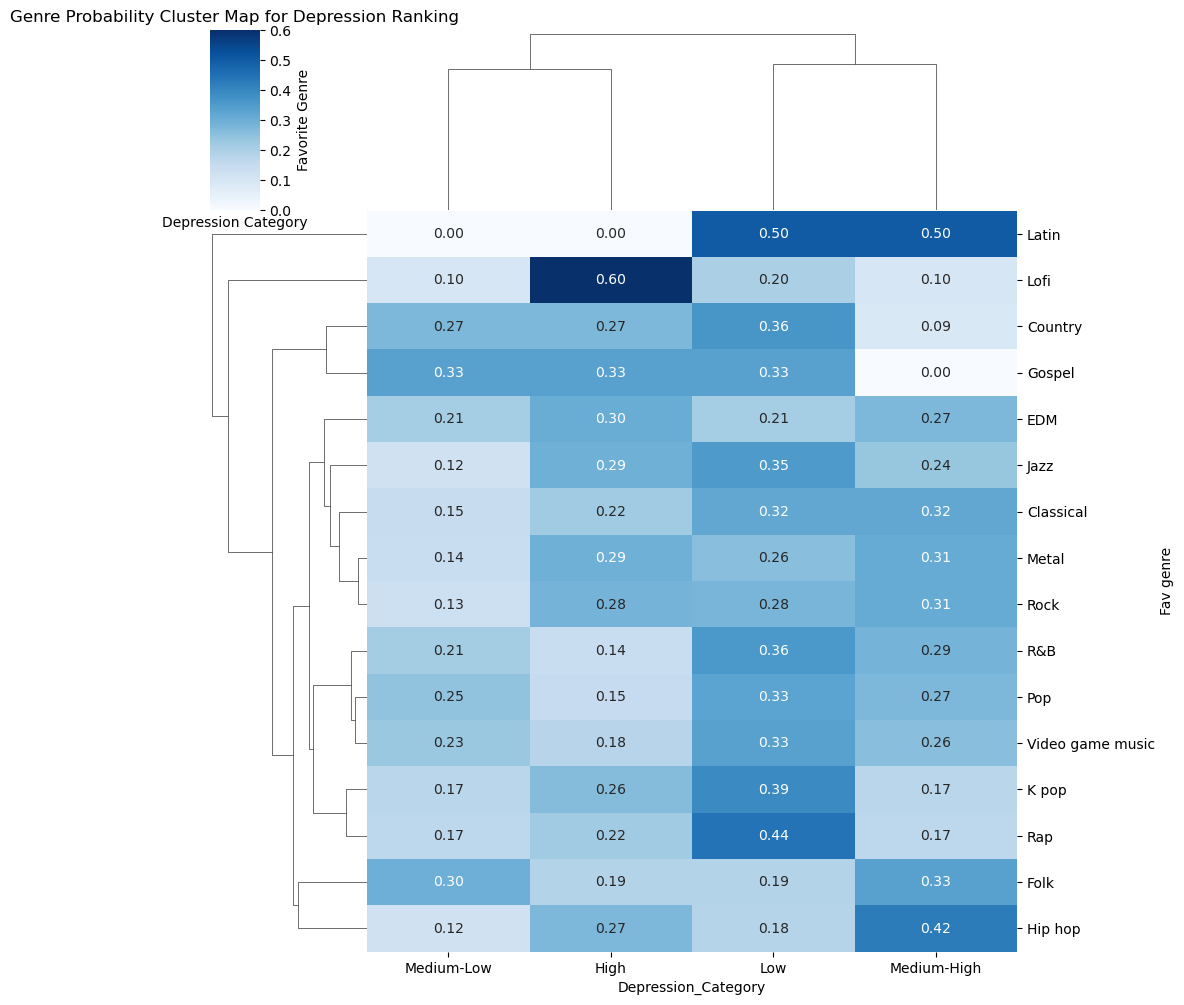

In [232]:

create_mg_genre_clustermap(mxmh_df, 'Depression')

Findings:
- Some correspondance of high depression and fav genre of Rock and Metal.

<Figure size 1000x800 with 0 Axes>

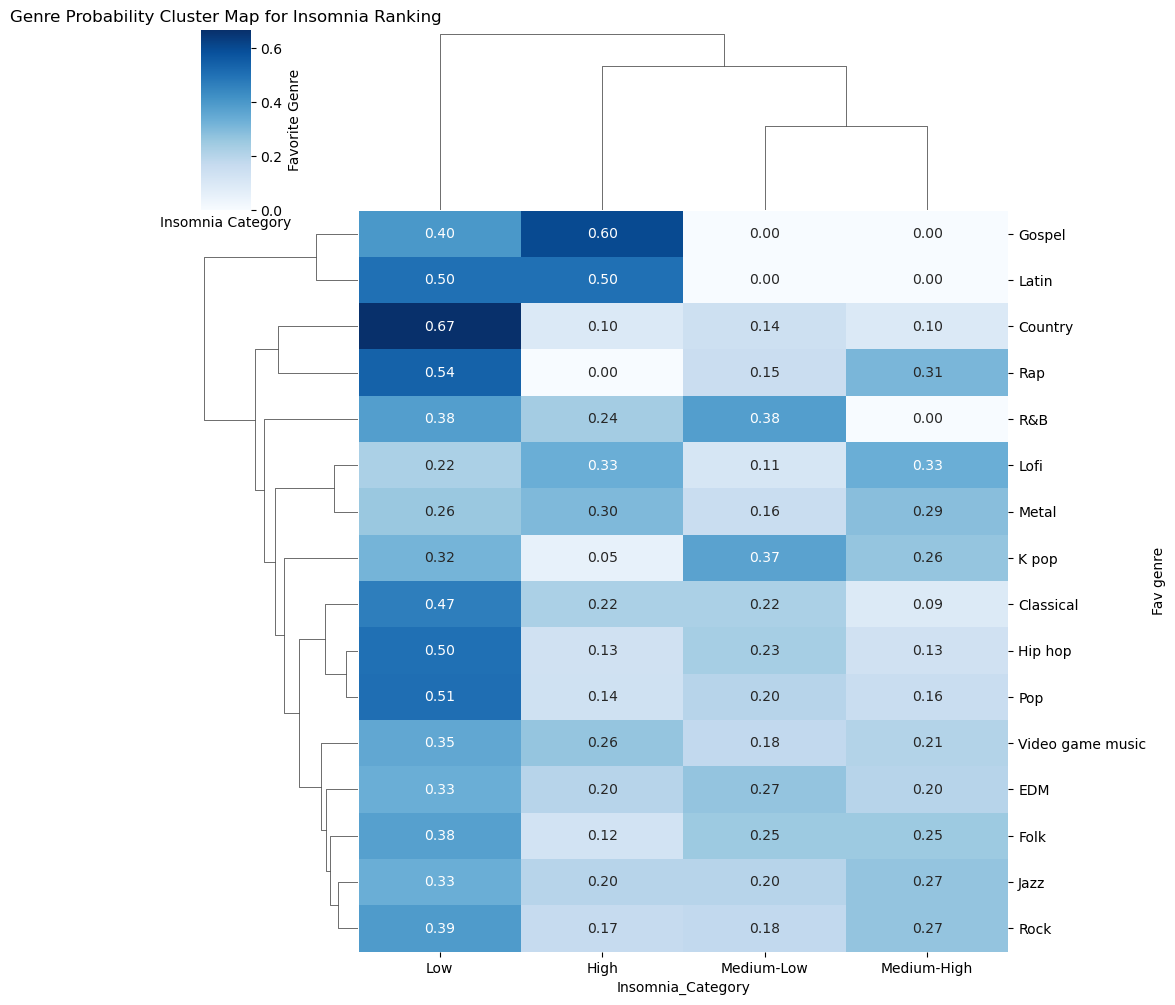

In [233]:
create_mg_genre_clustermap(mxmh_df, 'Insomnia')


Findings:
- Some correspondance of high insomnia and fav genre of metal.

<Figure size 1000x800 with 0 Axes>

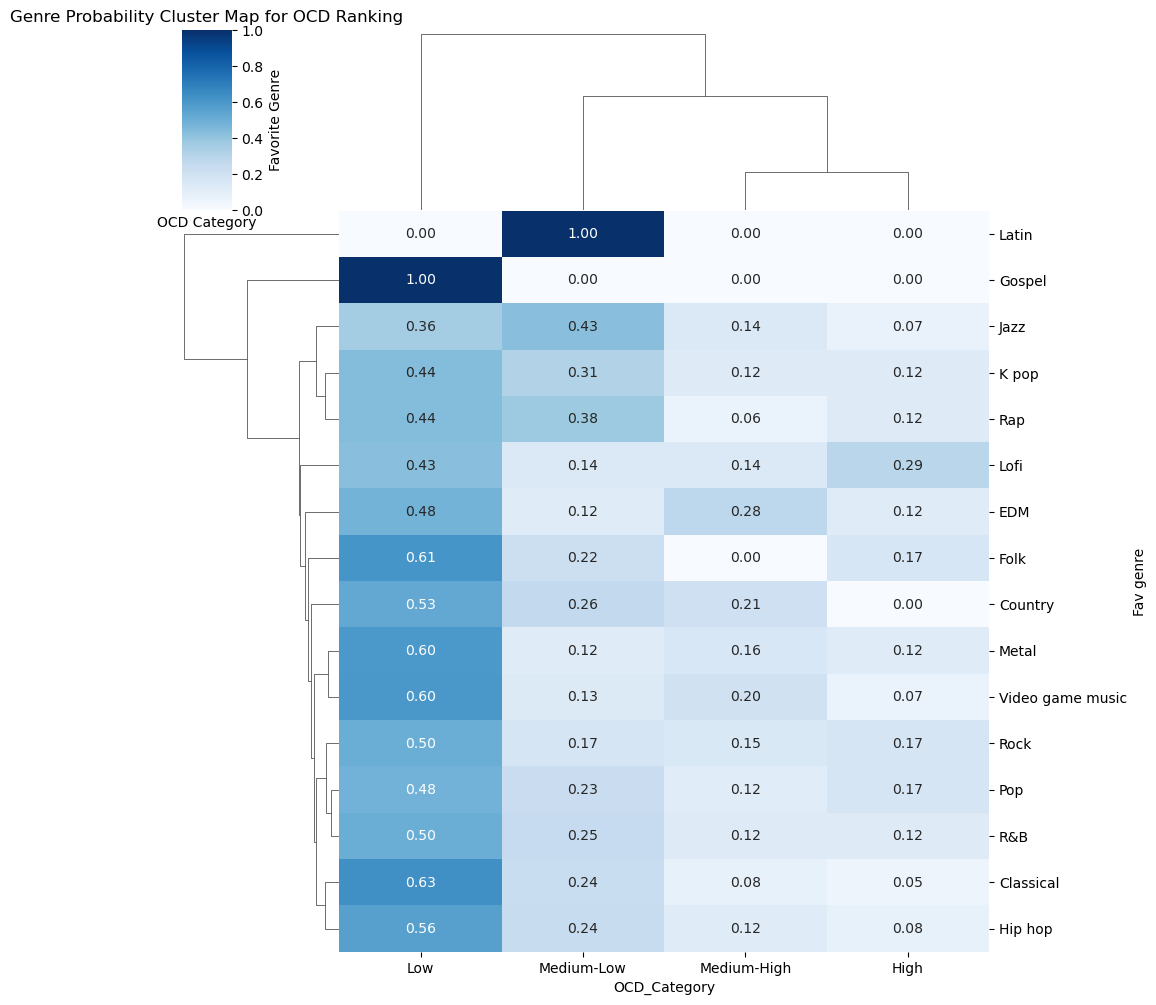

In [234]:
create_mg_genre_clustermap(mxmh_df, 'OCD')

Findings:
- No significant findings.

<Figure size 3000x1000 with 0 Axes>

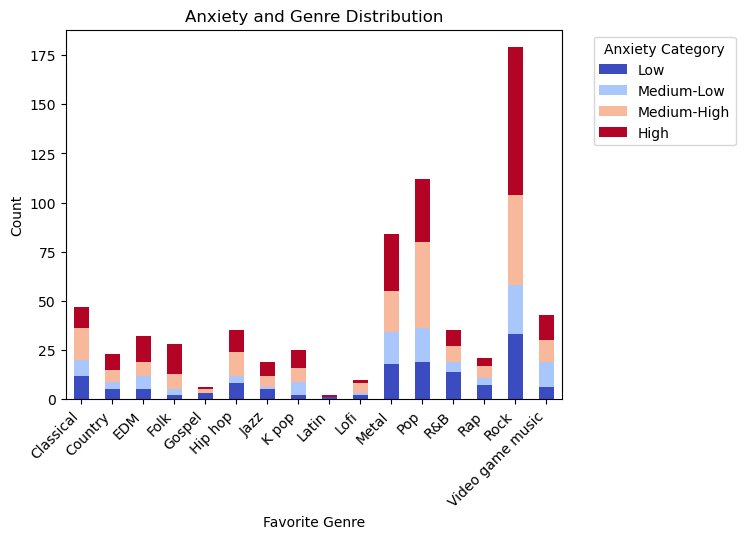

In [235]:
create_mh_genre_plot(mxmh_df, 'Anxiety')

<Figure size 3000x1000 with 0 Axes>

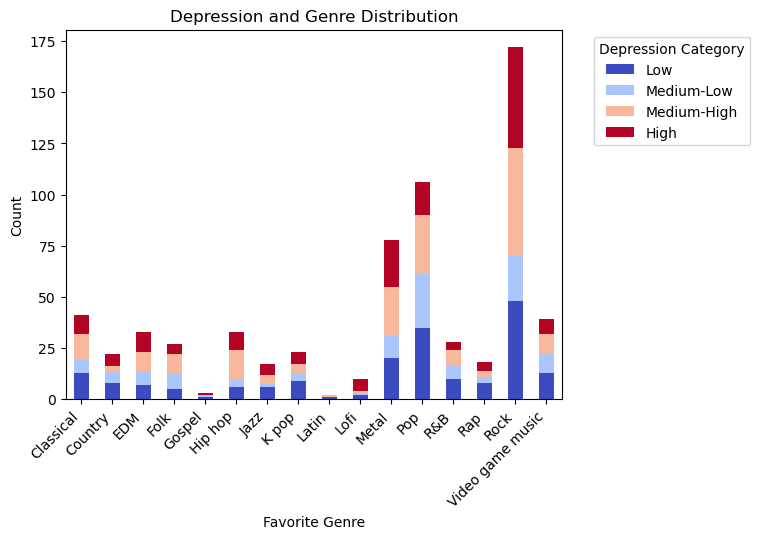

In [236]:
create_mh_genre_plot(mxmh_df, 'Depression')

<Figure size 3000x1000 with 0 Axes>

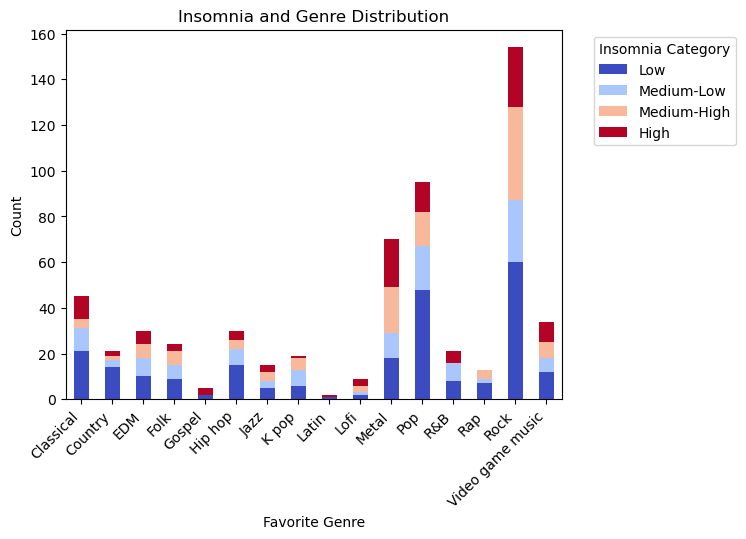

In [237]:
create_mh_genre_plot(mxmh_df, 'Insomnia')

<Figure size 3000x1000 with 0 Axes>

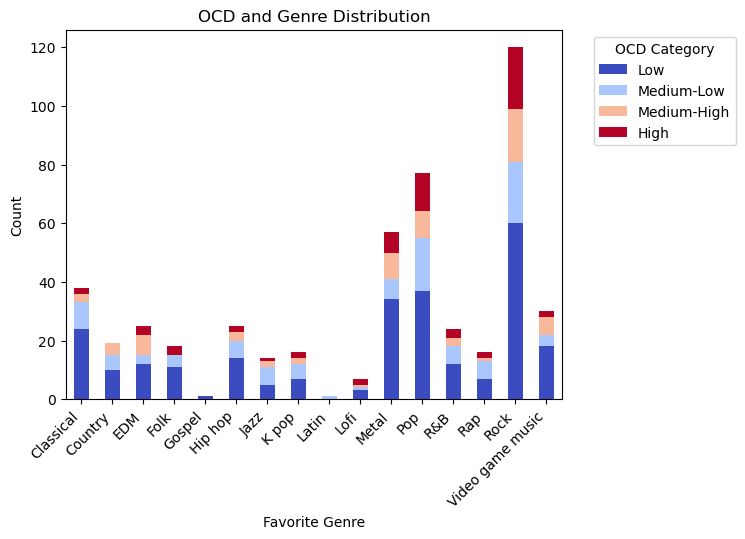

In [238]:
create_mh_genre_plot(mxmh_df, 'OCD')

## Summary

We were able to find some genres that had emotional trends. 

### Relevent Trends from Emotion Labeled Spotify Songs:
- High happiness distribution for Pop, Hip hop, Rap, Rock, and Country.
- High sadness distribution for Rock, Folk, Country, Jazz, and Gospel. 
- Low happiness distribution for Classical and Metal.
- Low sadness distribution for Hip hop, Rap, EDM, and Metal.

### Relevent insights from Music and Mental Health Survey:
- Recognizable correspondance of high anxiety and fav genre of Rock, Metal, and Pop.
- Some correspondance of high depression and fav genre of Rock and Metal.
- Some correspondance of high insomnia and fav genre of metal.

### Finding
- Many individuals with positive mental health rankings for Anxiety. 
- Low happiness distribution in Metal may relate to depression ranking but lack of evidence to say for sure. 
- Rap/Hip hop is tagged as happy, which is interesting. 